# STA 141B Final Project
Fall 2018

Xavier Hung

Weiyi Chen

## Problem: Is there a correlation between speeding and red light camera violations?
## Case study: Chicago

Many people are likely to speed up as they approach an intersection when the traffic light turns yellow.  It is dangerous and can sometimes lead to a fatal crash.  The red light camera is intended to increase public safety by preventing people from running a red light, but is it really effective?

This common occurrence brought us to analyze the association between red light violations and speeding. 

###  Data Extraction

We obtained our data from the City of Chicago. There are four CSV files: red light camera locations, red light camera violations, speed camera locations, and speed camera violations (details of these data can be found at https://data.cityofchicago.org/browse?q=red+light+camera&sortBy=relevance).  The two files speed camera violations and red light camera violations contain the daily number of speed violations and red light camera violations, respectively, since July 2014.

In [1]:
import os
import pandas as pd
import numpy as np
import math
from ast import literal_eval
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import Title
from bokeh.tile_providers import CARTODBPOSITRON
import numpy
from scipy.stats import linregress
from scipy.stats import spearmanr
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

redlight_loc = pd.read_csv('red-light-camera-locations.csv')
redlight_violations = pd.read_csv('red-light-camera-violations.csv')

speed_loc = pd.read_csv('speed-camera-locations.csv')
speed_violations = pd.read_csv('speed-camera-violations.csv')

`speed_loc` and `redlight_loc` have columns, latitude and longitude. We use Mercator projection to convert latitude and longitude into coordinates, and plot the locations of red light cameras and speed cameras.

The following interactive map shows the locations of all speed cameras and red light cameras in Chicago.

In [2]:
# plot red light cameras and speed cameras locations
speed_loc["COORDINATES"] = '('+ speed_loc["LATITUDE"].astype(str) +','+ speed_loc["LONGITUDE"].astype(str) + ')'
redlight_loc["COORDINATES"] = '('+ redlight_loc["LATITUDE"].astype(str) +','+ redlight_loc["LONGITUDE"].astype(str) + ')'

def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

speed_loc['coords_x'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc['coords_y'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc['coords_x'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc['coords_y'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9790000, -9735000), y_range=(5105000, 5165000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc['coords_x'], y = redlight_loc['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc['coords_x'], y = speed_loc['coords_y'], legend = "Speed Camera")

t = Title()
t.text = 'Locations of All Speed Cameras and Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In Chicago, 0.001 latitude is about 111.2 meters when longitude is constant. When latitude is constant, 0.001 longitude is about 82.69 meters.  This link provides the information: https://www.movable-type.co.uk/scripts/latlong.html

We subset the data by red light cameras and speed cameras that are near each other by 0.001 latitude and longitude.

In [3]:
# redlight_loc_copy is a subset of redlight_loc and contains the locations of red light cameras near speed cameras
# speed_loc_copy is a subset of speed_loc and contains the locations of speed cameras near red light cameras
redlight_loc_copy = pd.DataFrame(columns = redlight_loc.columns.values)
speed_loc_copy = pd.DataFrame(columns = speed_loc.columns.values)
pairs = pd.DataFrame(columns = ['speed', 'redlight'])

# find red light cameras near speed cameras
for i in range(0,speed_loc.shape[0]):
    for j in range(0,redlight_loc.shape[0]):
        if abs(speed_loc.iloc[i,4] - redlight_loc.iloc[j,5]) < 0.001 and abs(speed_loc.iloc[i,5] - redlight_loc.iloc[j,6]) < 0.001:
            #if pd.to_datetime(speed_loc['GO-LIVE DATE']).dt.year[i] < pd.to_datetime(redlight_loc['GO LIVE DATE']).dt.year[j]:
            redlight_loc_copy = redlight_loc_copy.append(redlight_loc.iloc[j], ignore_index = True)
            speed_loc_copy = speed_loc_copy.append(speed_loc.iloc[i], ignore_index = True)
            temp = pd.DataFrame({'speed': [speed_loc.iloc[i,0]], 'redlight': [redlight_loc.iloc[j,0]]})
            pairs = pairs.append(temp)
pairs = pairs.reset_index(drop = True)

In [4]:
# change format of addresses in speed_loc_copy to match format of addresses in speed_violations
remove = ["(Speed", "Camera)", "Ave", "ST", "Rd", "St", "Blvd"]
for i in range(0, speed_loc_copy.shape[0]):
    speed_loc_copy.iloc[i,0] = " ".join([word for word in speed_loc_copy.iloc[i,0].split() if word not in remove])

for i in range(0, pairs.shape[0]):
    pairs.iloc[i,0] = " ".join([word for word in pairs.iloc[i,0].split() if word not in remove]).upper()
    pairs.iloc[i,1] = pairs.iloc[i,1].upper()

speed_violations_copy = pd.DataFrame(columns = speed_violations.columns.values)    
    
# subset speed violations where speed cameras are near red light cameras
for i in range(0, speed_loc_copy.shape[0]):
    address = speed_violations[speed_violations['ADDRESS'].str.contains(speed_loc_copy.iloc[i,0].upper())]
    speed_violations_copy = speed_violations_copy.append(address, ignore_index = True)
    if len(address.index) > 0:
        pairs.iloc[i,0] = address.iloc[0,0]

In [ ]:
redlight_violations_copy = pd.DataFrame(columns = redlight_violations.columns.values)

# subset red light violations where speed cameras are near red light cameras
# this will take a while
for i in range (0, redlight_violations.shape[0]):
    for j in range(0, redlight_loc_copy.shape[0]):
        intersection1 = redlight_violations.iloc[i,0].replace(' AND ', '/').replace(' and ', '/').split('/')
        intersection2 = redlight_loc_copy.iloc[j,0].split('-')
        if len(intersection1) > 1 and len(intersection2) > 1:
            if intersection1[0] == intersection2[0].upper() or intersection1[0] == intersection2[1].upper():
                if intersection1[1] == intersection2[0].upper() or intersection1[1] == intersection2[1].upper():
                    redlight_violations_copy = redlight_violations_copy.append(redlight_violations.iloc[i], ignore_index = True)
                    pairs.iloc[j,1] = redlight_violations.iloc[i,0]

In [ ]:
print('There are ', len(pairs), ' location pairs that have red light cameras and speed cameras in close proximity.', sep = '')
print(pairs)
print('There are ', len(pairs['speed'].value_counts()), ' speed cameras.', sep = '')
print('There are ', len(pairs['redlight'].value_counts()), ' red light cameras.', sep = '')

There are 18 location pairs that have red light cameras and speed cameras in close proximity.
                       speed                 redlight
0             7826 S PULASKI         PULASKI AND 79TH
1          450 N COLUMBUS DR    COLUMBUS AND ILLINOIS
2             3217 W 55TH ST          55TH AND KEDZIE
3             3212 W 55TH ST          55TH AND KEDZIE
4             7833 S PULASKI         PULASKI AND 79TH
5          5532 S KEDZIE AVE          55TH AND KEDZIE
6         4123 N CENTRAL AVE  CENTRAL AND IRVING PARK
7             5428 S PULASKI         55TH and PULASKI
8           2335 W CERMAK RD       WESTERN AND CERMAK
9           732 N PULASKI RD      PULASKI AND CHICAGO
10            5030 S PULASKI       PULASKI AND ARCHER
11            4929 S PULASKI       PULASKI AND ARCHER
12            3534 N WESTERN      WESTERN AND ADDISON
13            5433 S PULASKI         55TH and PULASKI
14         449 N COLUMBUS DR    COLUMBUS AND ILLINOIS
15         324 E ILLINOIS ST    COLUMBUS A

These are the addresses of the 18 pairs of speed cameras and red light cameras, and we mapped them in the following plot.  There are 10 red light cameras.  At some intersections, there are more than one speed cameras that are near the red light cameras.  We can see the locations of each speed camera in the following interactive plot.

In [ ]:
# plot red light cameras near speed cameras
redlight_loc_copy["COORDINATES"] = '('+ redlight_loc_copy["LATITUDE"].astype(str) +','+ redlight_loc_copy["LONGITUDE"].astype(str) + ')'
speed_loc_copy["COORDINATES"] = '('+ speed_loc_copy["LATITUDE"].astype(str) +','+ speed_loc_copy["LONGITUDE"].astype(str) + ')'

speed_loc_copy['coords_x'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc_copy['coords_y'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc_copy['coords_x'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc_copy['coords_y'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9780000, -9745000), y_range=(5120000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc_copy['coords_x'], y = redlight_loc_copy['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc_copy['coords_x'], y = speed_loc_copy['coords_y'], legend = "Speed Camera",)

t = Title()
t.text = 'Speed Cameras in Close Proximity to Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

We will convert the daily violations to monthly violations, and plot speeding and red light camera violations over time at these 10 intersections, respectively.  For each intersection, we will compare the trend of speed violations with the red light camera violations, and calculate the Spearman’s correlation coefficient and the p-value to test for correlation (if any) since the data are nonparametric.

We analyze the 10 intersections in the order of most red light camera violations to the least red light camera violations.  The red light camera violations are represented by in the following plots.

The Spearman rank correlation coefficient and p-value for speed violations at 449 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.162963453255 and 2.78044192069e-52, respectively.
The Spearman rank correlation coefficient and p-value for speed violations at 450 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS are 0.264360762275 and 2.79546990715e-134, respectively.
The Spearman rank correlation coefficient and p-value for speed violations at 324 E ILLINOIS ST and red light violations at COLUMBUS AND ILLINOIS are -0.0754133215296 and 0.00111370502749, respectively.


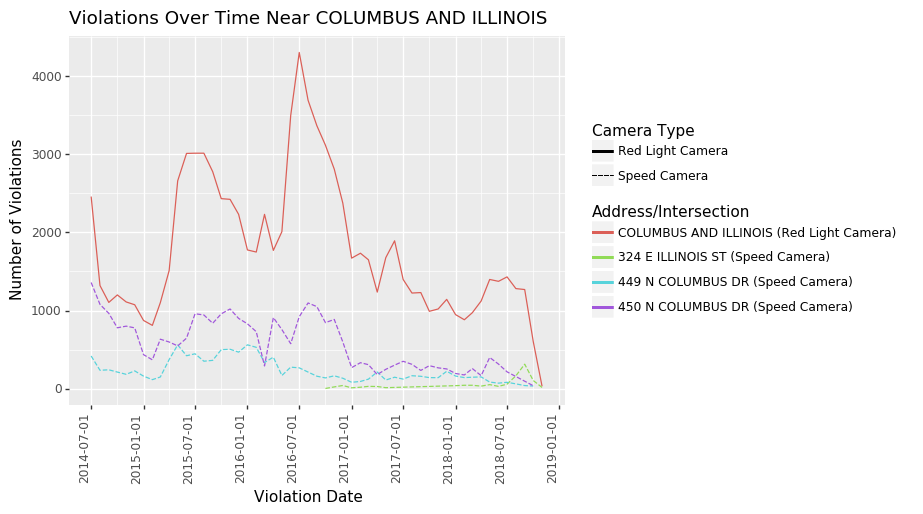

<ggplot: (-9223372036563643262)>


In [ ]:
redlight = redlight_violations_copy.groupby('INTERSECTION')['VIOLATIONS'].sum().sort_values(ascending = False)

# output in order of most red light violations to least red light violations
# for loop to find correlations and plots for all red light cameras and speed cameras pairs
# this will take a while
for i in range(0, len(redlight)):
    rlc_violation_intersection = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][i])].reset_index(drop = True)

    rlc_speed = pd.DataFrame()
    temp = pairs.loc[pairs['redlight'] == rlc_violation_intersection.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
    for j in range(0, len(temp)):
        rlc_speed = rlc_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[j])].reset_index(drop = True))

    temp1 = rlc_speed
    temp1['VIOLATION DATE'] = pd.to_datetime(temp1['VIOLATION DATE'])
    temp2 = rlc_violation_intersection
    temp2['VIOLATION DATE'] = pd.to_datetime(temp2['VIOLATION DATE'])
    
    # for loop to find correlations
    for k in range(0, len(temp1['ADDRESS'].value_counts())):
        temp = temp1.loc[temp1['ADDRESS'] == temp1['ADDRESS'].value_counts().index[k]]
        x1 = pd.DataFrame()
        x2 = pd.DataFrame()
        # loop to find speed violations and red light violations that occur on the same day
        for l in range(0, len(temp)):
            for m in range(0, len(temp2)):
                if(temp['VIOLATION DATE'][l] == temp2['VIOLATION DATE'][m]):
                    x1 = x1.append(temp.iloc[l])
                    x2 = x2.append(temp2.iloc[m])
        #print('The Pearson correlation coefficient for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', numpy.corrcoef(x1['VIOLATIONS'], x2['VIOLATIONS'])[0,1], '.', sep = '')
        #print('R-squared for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' is ', linregress(x1['VIOLATIONS'], x2['VIOLATIONS'])[2] ** 2, '.', sep = '')
        print('The Spearman rank correlation coefficient and p-value for speed violations at ', temp.iloc[0,0], ' and red light violations at ', x2.iloc[0,2], ' are ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[0], ' and ', spearmanr(x1['VIOLATIONS'], x2['VIOLATIONS'])[1], ', respectively.', sep = '')
    
    #convert daily violations to months for speed cameras
    rlc_speed['date'] = pd.to_datetime(rlc_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_speed['date'] = pd.to_datetime(rlc_speed['date'])
    temp = rlc_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
    plotdata_speed = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})
    plotdata_speed['CAMERA_TYPE'] = 'Speed Camera'

    #convert daily violations to months for red light cameras
    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
    rlc_violation_intersection['date'] = pd.to_datetime(rlc_violation_intersection['date'])
    temp = rlc_violation_intersection.groupby('date')['VIOLATIONS'].sum()
    plotdata_redlight = pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': rlc_violation_intersection.iloc[0,0]})
    plotdata_redlight['CAMERA_TYPE'] = 'Red Light Camera'

    # drop months where there are no red light camera violations or speed violations
    plotdata_speed = plotdata_speed.loc[plotdata_speed['count'] != 0]
    plotdata_redlight = plotdata_redlight.loc[plotdata_redlight['count'] != 0]

    plotdata_speed['ADDRESS'] += ' (Speed Camera)'
    plotdata_redlight['ADDRESS'] += ' (Red Light Camera)'

    print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS', linetype = 'CAMERA_TYPE'), data = plotdata_redlight)
      + geom_line()
      + geom_line(aes(x = 'date', y = 'count', color = 'ADDRESS', linetype = 'CAMERA_TYPE'), data = plotdata_speed)
      + labs(x = 'Violation Date', y = 'Number of Violations', color = 'Address/Intersection', linetype = 'Camera Type')
      + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
      + ggtitle('Violations Over Time Near ' + rlc_violation_intersection.iloc[0,0]))

### Data Analysis

#### 1. Near COLUMBUS AND ILLINOIS (intersection with the most red light camera violations)

Between the speed violations at 449 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS, there is a very weak, positive correlation (ρ = 0.16296, p < 0.001).  The speeding violations are increasing then decreasing within a narrow range.  The trend is roughly similar to the red light violations.

Between the speed violations at 450 N COLUMBUS DR and red light violations at COLUMBUS AND ILLINOIS, there is a weak, positive correlation (ρ = 0.26436, p < 0.001).  Since Spearman correlation measures monotonic relationship, the low coefficient does not mean weak correlation.  From the graph, the trend of red light violations at COLUMBUS AND ILLINOIS is nearly the same as the trend of speed violations at 450 N COLUMBUS DR ().  They increase and decrease almost at the same time, thus we believe, there is a somehow strong correlation between them.

There is a very weak, negative correlation between speed violations at 324 E ILLINOIS ST and red light violations at COLUMBUS AND ILLINOIS (ρ = -0.07541, p = 0.0011).  From the plot, we see that there are very few speeding violations at 324 E ILLINOIS ST, so we assume this is a newly installed speed camera.

We also find it interesting that the summer months have the peak number of violations.  This may be because there are more drivers on the streets during the summer and people may be more reluctant to drive during the winter when there is snow.  The overall violations appear to decrease over time.

#### 2. Near PULASKI AND ARCHER (intersection with the second most red light camera violations)

Between the speed violations at 5030 S PULASKI and red light violations at PULASKI AND ARCHER, there is a very weak, positive correlation (ρ = 0.08581, p < 0.001).  Between the speed violations at 4929 S PULASKI and red light violations at PULASKI AND ARCHER, there is also a very weak, positive correlation(ρ = 0.08056, p < 0.001).  Although the coefficients are small, we see from the plot that the three lines change in the same pattern.  Thus, there are moderate correlations between these two pairs.

There is no big change in red light camera violations and speed violations at 4929 S PULASKI.  Again, the summer months have the peak number of violations.  For speed violations at 5030 S PULASKI, there are nearly 3,000 speed violations per month in summer 2014, about 1,800 violations per month in summer 2015, and around 1,000 violations per month in summer 2016, 2017, 2018.  Since 2016, the majority of monthly violations stay below 1,000.

#### 3. Near PULASKI AND 79TH (intersection with the third most red light camera violations)

There is almost no correlation between the speed violations at 7833 S PULASKI and red light violations at PULASKI AND 79TH (ρ = 0.04217, p = 0.03).  There is also almost no correlation between the speed violations at 7826 S PULASKI and red light violations at PULASKI AND 79TH (ρ = 0.01414, p = 0.47).

The number of red light camera violations periodically fluctuates with the highest during the summer and lowest during the winter.  The speed violations at 7826 S PULASKI are few and flat.  The speed violations at 7833 S PULASKI dramatically drop from July 2014, and the overall speed violations decrease slightly over time.

#### 4. Near 55TH AND KEDZIE

There is almost no correlation between the speed violations at 5532 S KEDZIE AVE and red light violations at 55TH AND KEDZIE (ρ = 0.01964, p = 0.304).  There is very weak correlation between the speed violations at 3212 W 55TH ST and red light violations at 55TH AND KEDZIE (ρ = -0.04290, p = 0.065).  There is almost no correlation between the speed violations at 3217 W 55TH ST and red light violations at 55TH AND KEDZIE (ρ = 0.01925, p = 0.450).

We see a trend of increasing red light camera violations.  The trend for speed violations at 3212 W 55TH ST and at 3217 W 55TH ST are similar in pattern, with both being low and flat.  There are two large spikes in the number of speed violations at 5532 S KEDZIE AVE in 2015 (the first year of use).  Then, the number of speeding violations declines significantly (below 100).

#### 5. Near COTTAGE GROVE AND 71ST

Since the two speed cameras near COTTAGE GROVE AND 71ST, were installed recently, there is not enough information. 

The number of red-light running fluctuates within a small range and slightly increases over time.

#### 6. Near 55TH and PULASKI

Between the speed violations at 5433 S PULASKI and red light violations at 55TH and PULASKI, there is a very weak, positive correlation (ρ = 0.05137, p < 0.013).  Between the speed violations at 5428 S PULASKI and red light violations at 55TH and PULASKI, there is a very weak, positive correlation (ρ = 0.12641, p < 0.001).  Although the coefficients are small, we see from the plot that the three lines follow a similar trend.  Thus, there are moderate correlations between these two pairs.

The overall violations appear to decrease over time.

#### 7. Near WESTERN AND ADDISON

There is a very weak, positive correlation between speed violations at 3534 N WESTERN and red light violations at WESTERN AND ADDISON (ρ = 0.08297, p = 0.01).

The speed violations have no data from April 2016 to August 2017.  The numer of speed violations and red light violations are relatively high during the summer.

#### 8. Near WESTERN AND CERMAK

There is almost no correlation between speed violations at 2335 W CERMAK RD and red light violations at WESTERN AND CERMAK (ρ = 0.01265, p = 0.69).

Red light camera violations are relatively low in 2015, and it also shows the spikes during the summer months.  However, the number of speed violations are highest in 2015, but then it increases dramatically during the summer in 2016 and then decreases during the winter where it stays around 50 in the following years.

#### 9. Near PULASKI AND CHICAGO

There is almost no correlation between speed violations at 732 N PULASKI RD and red light violations at PULASKI AND CHICAGO (ρ = -0.03055, p = 0.27).

The number of red light camera violations appears to increase and the number of speed camera violations appears to decrease over time.

#### 10. Near CENTRAL AND IRVING PARK (intersection with the least red light camera violations)

There is a very weak, negative correlation between speed violations at 4123 N CENTRAL AVE and red light violations at CENTRAL AND IRVING PARK (ρ = -0.02611, p = 0.19879).  The number of monthly red light violations is mostly between 100 to 200.  However, the number of speed violations appears to spike during the winter months, which is in contrast to our previous finding that the highest number of violations occurs during the summer.  Moreover, there is a sharp drop in the number of speed violations to almost 0 between July 2015 and December 2015. It is highly unlikely that the number of speeding violations during this period is in the single digits, so we assume that the speed camera was offline for a few weeks.

### Conclusion

Since our data does not follow a normal distribution and does not exihibit a linear relationship, we chose Spearman's correlation instead of Pearson's correlation to measure the strength of the relationship between paired data.  However, the Spearman's rank correlation may not be the best statistic to determine this strength since our data is not monotonic.  All of the Spearman rank correlation coefficients for the location pairs either had very weak or almost no correlation except for the ones at COLUMBUS AND ILLINOIS and COTTAGE GROVE AND 71ST, which both had weak correlations.

We also found that the number of speed camera violations and red light camera violations tended to spike during the summer months with the exception of the intersection CENTRAL AND IRVING PARK, which had the highest number of violations during the winter months.

Ultimately, there is insufficient evidence to conclude that there is a correlation between red light violations and speed violations.  We cannot conclude that red light cameras are effective at preventing people from running a red light